In [1]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import timm
from timm import optim, scheduler
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import transforms as tfm
from sklearn import metrics as skmet
from jupyterplot import ProgressPlot

%aimport dataset
%aimport train
%aimport model
ImageData = dataset.ImageData
AE = model.AE_timm

UsageError: Line magic function `%aimport` not found.


In [5]:
test_frac = 0.2 # fraction of images used for testing
bs_train = 32  # batch size for training
bs_test = 50  # batch size for testing
num_workers = 10  # number of parallel data loading workers
res = 224 # pixel size along height and width
device = torch.device('cuda:0')
num_classes = 3
model = 'resnet50d'
num_epochs=5
lr = 0.001
lr_gamma = 0.9#0.92611872812  # lr_gamma^30 = 0.1
dropout = 0.3
weight_decay = 0.00001
pretrained=True
keep_views = None
unfreeze_after_n=20

In [6]:
df_img = pd.read_csv('../data/model_images.csv')
df_trg = pd.read_csv('../data/model_targets.csv')

In [7]:
# use full-size images for autoencoding
df_img['path'] = df_img['path'].str.replace('/cropped_images/', '/exported_jpgs/')
df_img

patient_id             external_id  \
0       AN00001        AN00001_Y_VIEW_4   
1       AN00010           AN00010__1001   
2       AN00100      AN00100_AXILLARY_4   
3       AN00100  AN00100_EXT_ROTATION_1   
4       AN00100  AN00100_INT_ROTATION_2   
...         ...                     ...   
1037    AN00099    AN00099_Shoulder_R_2   
1038    AN00099    AN00099_Shoulder_R_3   
1039    AN00001      AN00001_AXILLARY_3   
1040    AN00001  AN00001_EXT_ROTATION_2   
1041    AN00001  AN00001_INT_ROTATION_1   

                                                  path view view_group  
0           ../data/exported_jpgs/AN00001_Y_VIEW_4.jpg    Y          Y  
1              ../data/exported_jpgs/AN00010__1001.jpg   AP    AP_LIKE  
2         ../data/exported_jpgs/AN00100_AXILLARY_4.jpg   AX       AXIL  
3     ../data/exported_jpgs/AN00100_EXT_ROTATION_1.jpg   AP    AP_LIKE  
4     ../data/exported_jpgs/AN00100_INT_ROTATION_2.jpg   AP    AP_LIKE  
...                                                ...  ...        ...  
1037    ../data/exported_jpgs/AN00099_Shoulder_R_2.jpg   AP    AP_LIKE  
1038    ../data/exported_jpgs/AN00099_Shoulder_R_3.jpg   AP    AP_LIKE  
1039      ../data/exported_jpgs/AN00001_AXILLARY_3.jpg   AX       AXIL  
1040  ../data/exported_jpgs/AN00001_EXT_ROTATION_2.jpg   AP    AP_LIKE  
1041  ../data/exported_jpgs/AN00001_INT_ROTATION_1.jpg   AP    AP_LIKE  

[1042 rows x 5 columns]

In [8]:
df_trg_train, df_trg_test = train_test_split(df_trg, test_size=test_frac, stratify=df_trg['fracture_type'], shuffle=True)
df_train = df_trg_train.merge(df_img)
df_test = df_trg_test.merge(df_img)
df_train.shape, df_test.shape

((847, 7), (195, 7))

In [9]:
tfms_train = tfm.Compose([
    tfm.Resize(res),
    tfm.RandomCrop(res),
    tfm.RandomEqualize(p=0.5),
    tfm.RandAugment(),
    tfm.ToTensor(),
    tfm.Normalize(mean=torch.Tensor([0.4850, 0.4560, 0.4060]), std=torch.Tensor([0.2290, 0.2240, 0.2250])),
    tfm.RandomHorizontalFlip(),
    tfm.RandomRotation((-45, 45)),
    # tfm.RandomInvert(),
    tfm.Grayscale()
])

tfms_test = tfm.Compose([
    tfm.Resize(res),
    tfm.RandomCrop(res),
    tfm.ToTensor(),
    tfm.Normalize(mean=torch.Tensor([0.4850, 0.4560, 0.4060]), std=torch.Tensor([0.2290, 0.2240, 0.2250])),
    tfm.Grayscale()
])

In [10]:
def train_one_epoch(model, train_dataloader, loss_function, device):
    model.train()

    num_steps_per_epoch = len(train_dataloader)

    losses = []
    for ix, batch in enumerate(train_dataloader):
        x = batch['img'].to(device)
        xhat = model(x)
        loss = loss_function(xhat, x)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach().item())
        print(f"\tBatch {ix+1} of {num_steps_per_epoch}. Loss={loss.detach().item():0.3f}", end='\r')
    
    print(' '*100, end='\r')
        
    return np.mean(losses)
            
            
def evaluate(model, test_dataloader, loss_function, device):
    model.eval()

    num_steps_per_epoch = len(test_dataloader)

    losses = []
    for ix, batch in enumerate(test_dataloader):
        x = batch['img'].to(device)
        with torch.no_grad():
            xhat = model(x)
            loss = loss_function(xhat, x)
            
        losses.append(loss.detach().item())
        
    return np.mean(losses)

In [11]:
test_img = torch.randn(1,1,res,res)

In [12]:
# create datasets
d_train = ImageData(df_train, transforms = tfms_train, view_filter=keep_views)
dl_train = DataLoader(d_train, batch_size=bs_train, num_workers=num_workers, shuffle=True)

d_test = ImageData(df_test, transforms = tfms_test, view_filter=keep_views)
dl_test = DataLoader(d_test, batch_size=bs_test, num_workers=num_workers)

# create model
ae = AE(model).to(device)

# freeze encoder weights
# don't freeze first conv/bn block because model was pretrained on imagenet and we're using 1 input channel
if pretrained: 
    for layer in list(ae.encoder.children())[2:]:
        for p in layer.parameters():
            p.requires_grad = False
    is_frozen=True
else:
    is_frozen=False

# fit
optimizer = optim.AdamP(ae.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ExponentialLR(optimizer, gamma=lr_gamma)
loss_function = torch.functional.F.mse_loss

train_loss_ls = []
test_loss_ls = []

# progress plot
pp = ProgressPlot(x_lim=[1,num_epochs], plot_names = ['MSE'], x_label="Epoch", line_names=['train', 'test'])

for epoch in range(num_epochs):
    print("-"*40)
    print(f"Epoch {epoch+1} of {num_epochs}:")

    # maybe unfreeze 
    if epoch >= unfreeze_after_n and is_frozen:
        print("Unfreezing model encoder.")
        is_frozen=False
        for p in ae.encoder.parameters():
            p.requires_grad = True

    # train for a single epoch
    train_loss = train_one_epoch(ae, dl_train, loss_function, device)
    train_loss_ls.append(train_loss)
    print(f"Training:")
    print(f"\tMSE = {train_loss:0.3f}")       

    # evaluate
    test_loss = evaluate(ae, dl_test, loss_function, device)
    test_loss_ls.append(test_loss)
    print(f"Test:")
    print(f"\tMSE = {test_loss:0.3f}")

    scheduler.step()

    pp.update([[train_loss, test_loss]])

pp.finalize()

/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/xiaofey/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


model.safetensors:   0%|          | 0.00/103M [00:00<?, ?B/s]

The given encoder outputs a feature map with 2048 channels


----------------------------------------
Epoch 1 of 5:
Training:                                                                                           
	MSE = 1.623
Test:
	MSE = 1.673
----------------------------------------
Epoch 2 of 5:
Training:                                                                                           
	MSE = 1.163
Test:
	MSE = 1.366
----------------------------------------
Epoch 3 of 5:
Training:                                                                                           
	MSE = 0.754
Test:
	MSE = 0.575
----------------------------------------
Epoch 4 of 5:
Training:                                                                                           
	MSE = 0.628
Test:
	MSE = 0.505
----------------------------------------
Epoch 5 of 5:
Training:                                                                                           
	MSE = 0.564
Test:
	MSE = 0.491


In [13]:
import matplotlib.pyplot as plt

In [14]:
test_batch = next(iter(dl_test))

In [18]:
torch.save(ae.state_dict(), f'/home/xiaofey/xray/xray-master/code/ae_{model}.ckpt')

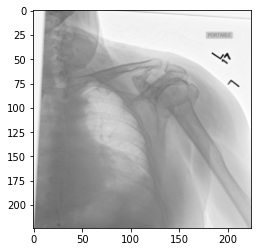

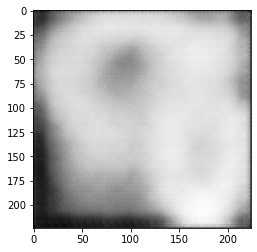

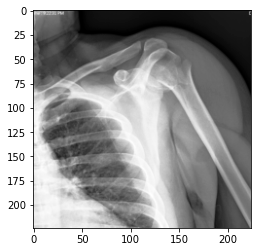

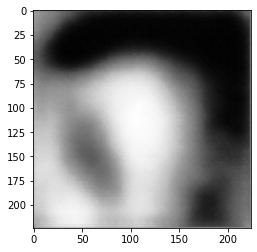

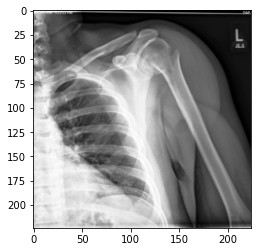

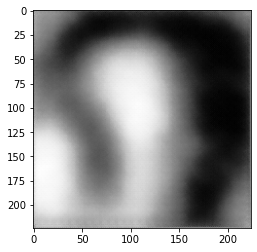

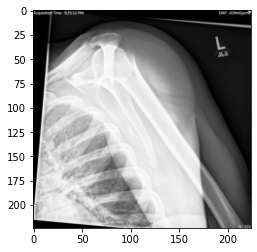

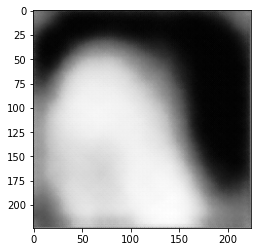

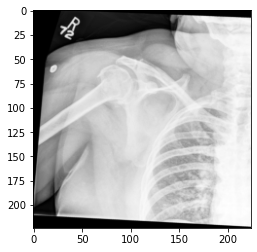

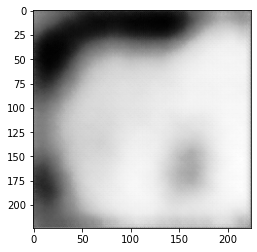

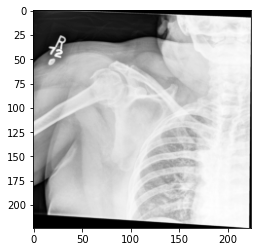

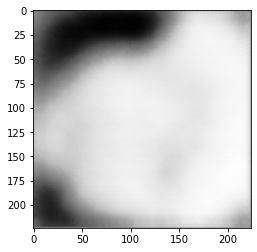

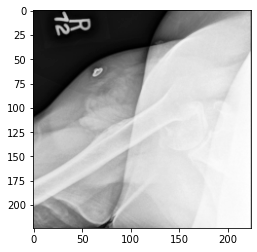

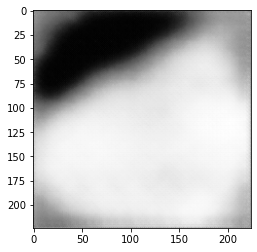

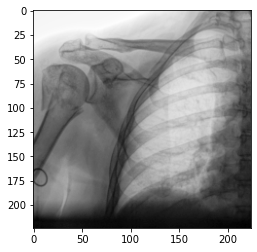

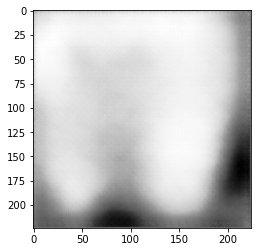

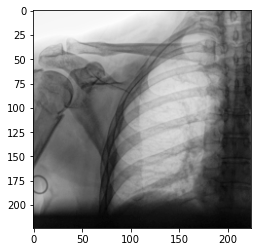

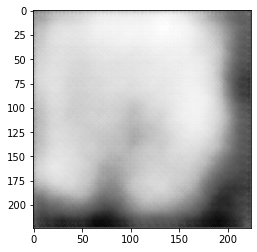

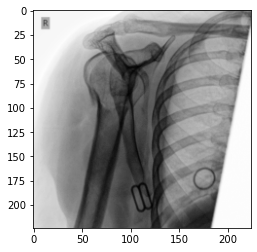

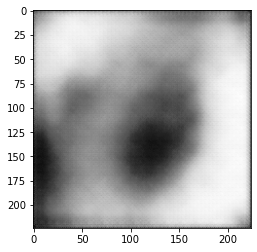

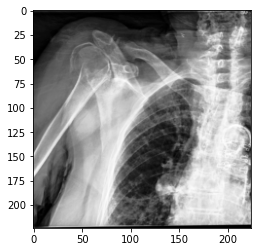

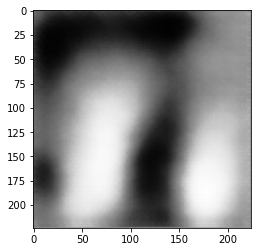

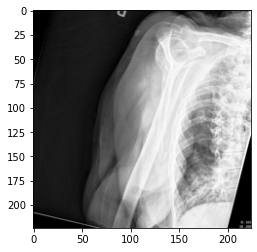

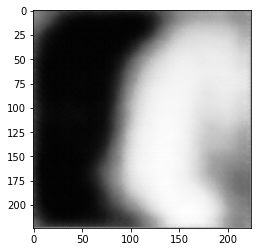

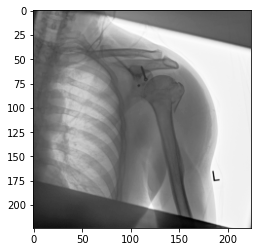

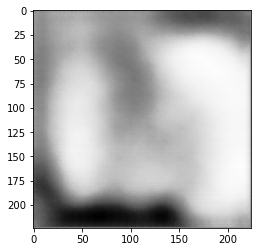

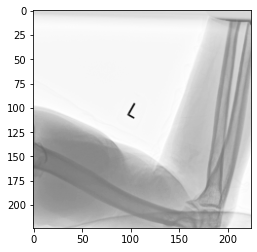

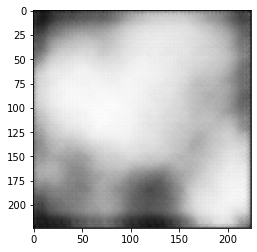

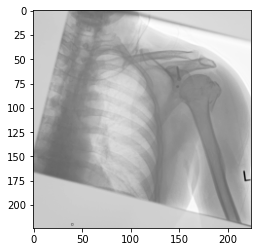

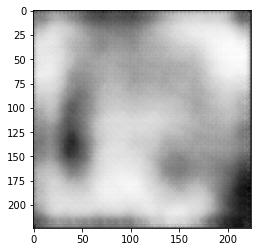

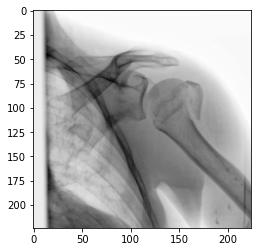

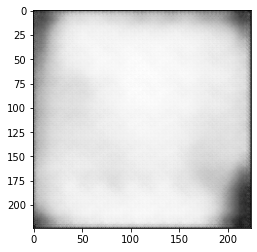

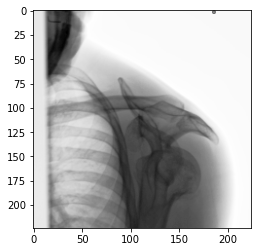

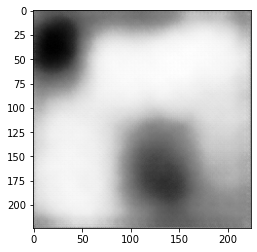

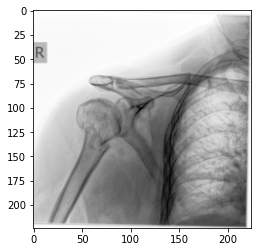

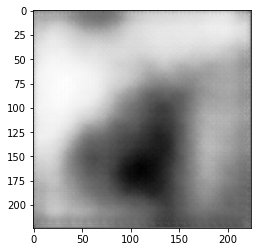

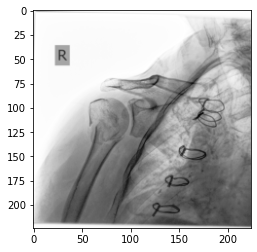

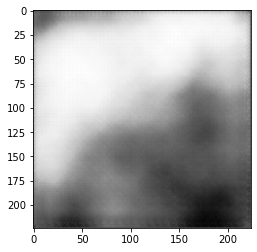

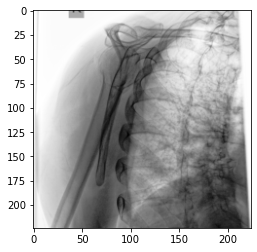

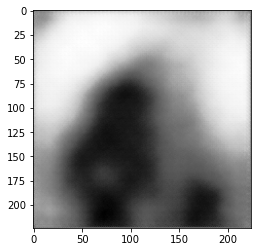

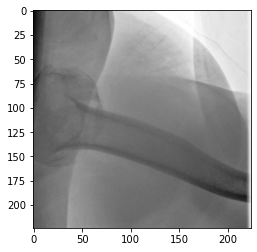

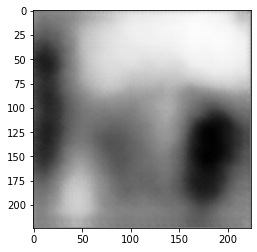

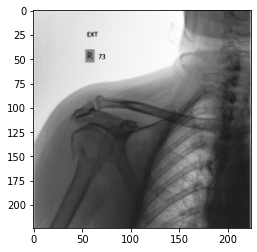

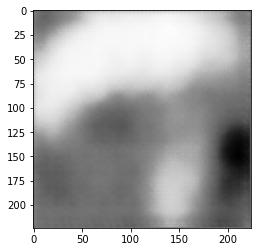

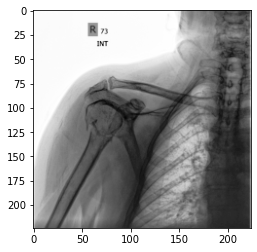

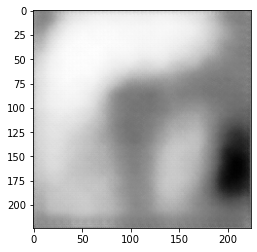

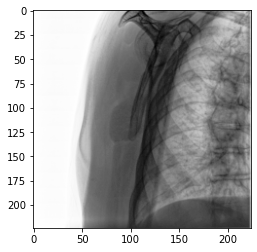

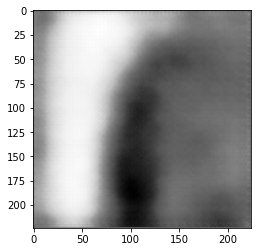

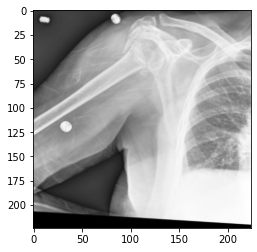

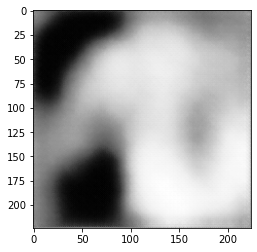

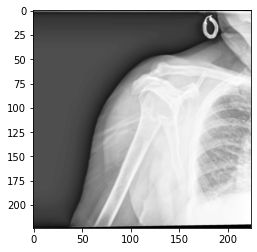

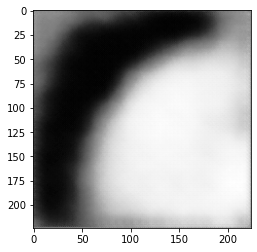

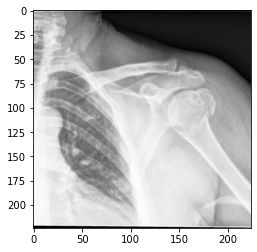

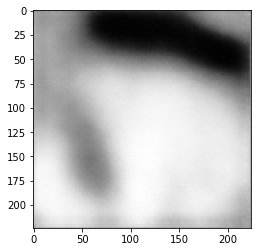

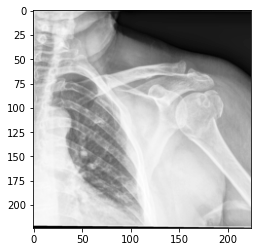

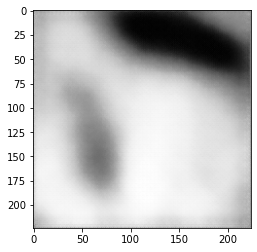

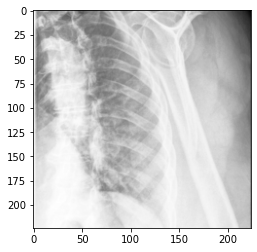

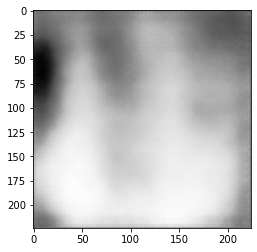

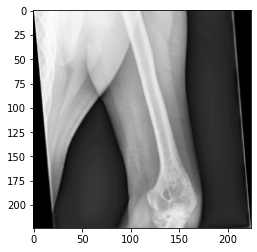

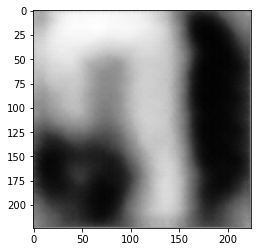

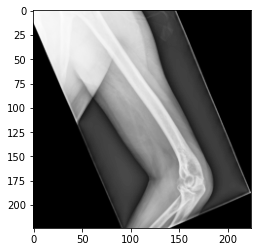

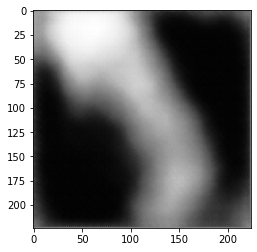

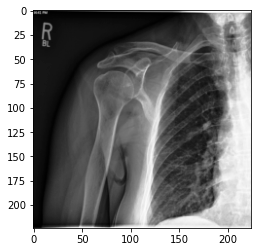

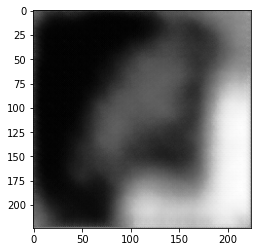

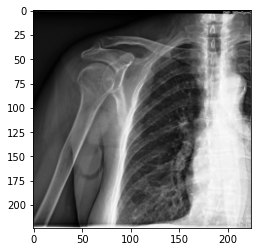

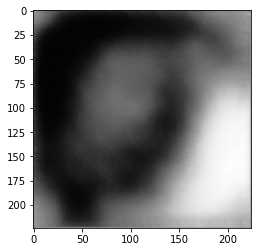

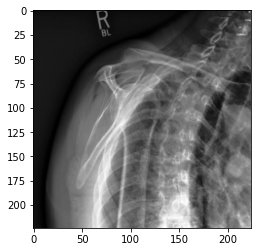

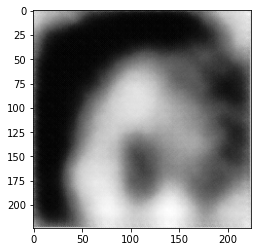

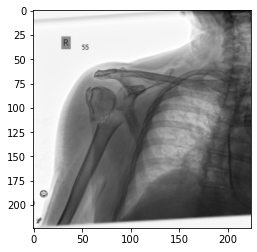

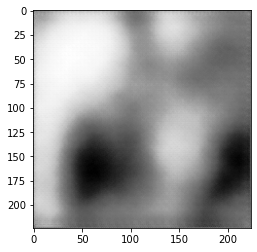

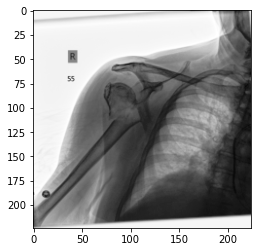

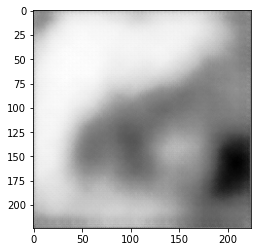

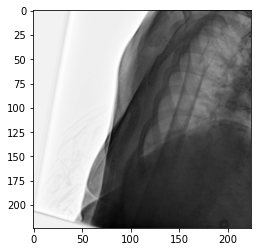

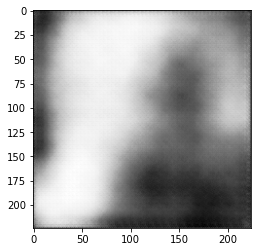

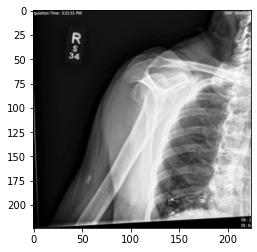

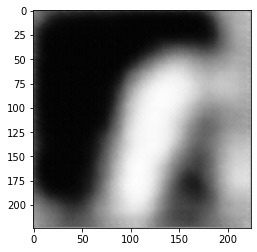

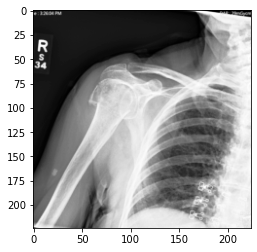

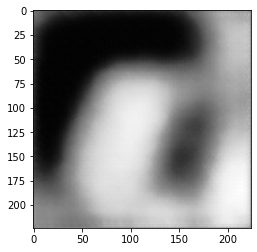

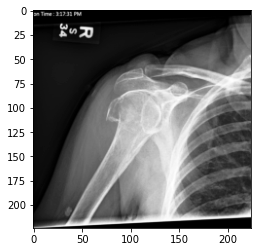

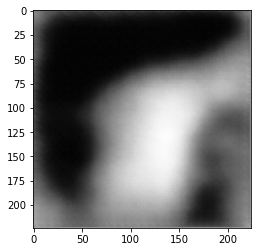

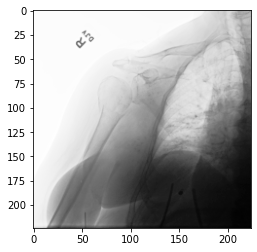

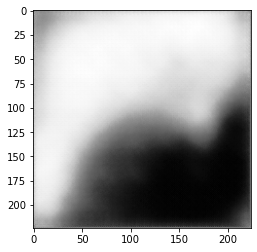

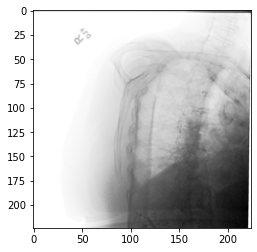

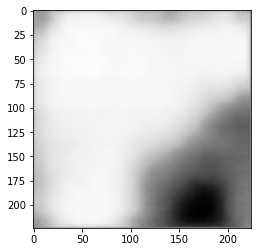

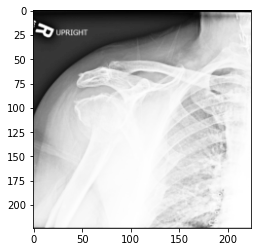

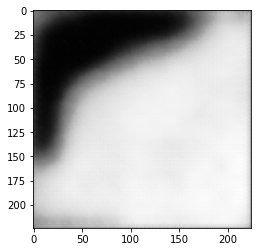

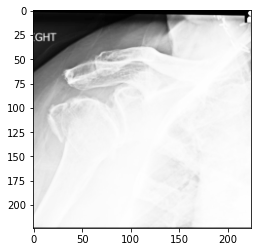

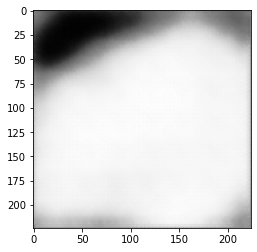

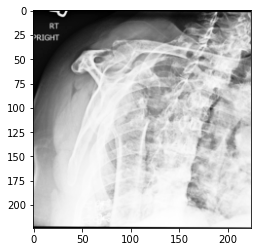

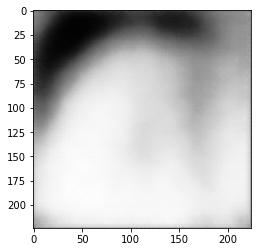

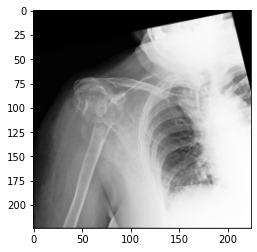

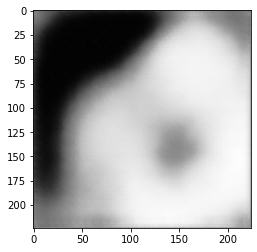

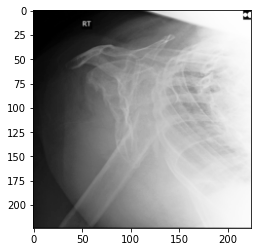

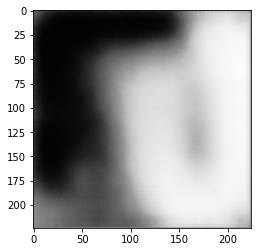

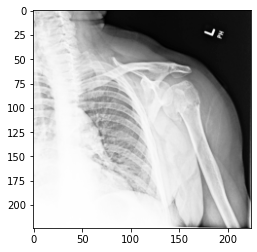

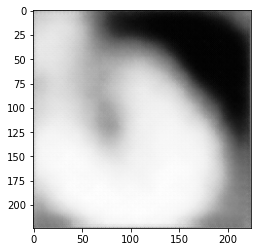

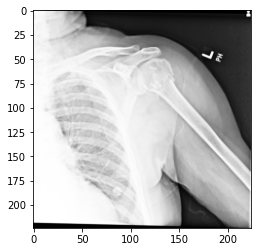

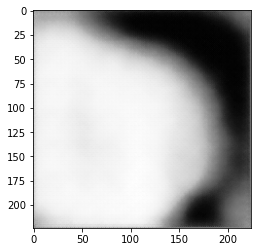

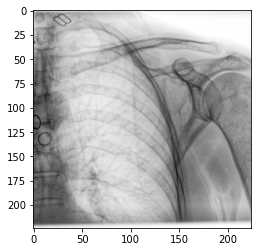

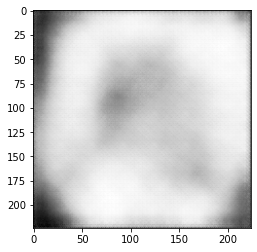

In [19]:
im = test_batch['img']
with torch.no_grad():
    im_hat = ae.eval()(im.to(device)).cpu()
    
im, im_hat = im.squeeze().numpy(), im_hat.squeeze().numpy()
for ix in range(bs_test):
    plt.imshow(im[ix], cmap='Greys_r')
    plt.show()
    plt.imshow(im_hat[ix], cmap='Greys_r')
    plt.show()